In [1]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
# LOW LEVEL
from tensorflow.keras.layers import Flatten

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
def read_mnist(images_path: str, labels_path: str):
    #mnist_path = "data/mnist/"
    #images_path = mnist_path + images_path
    print(images_path)
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [4]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz


In [5]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


In [6]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

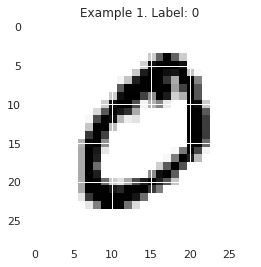

In [7]:
display_image(1)

In [8]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [9]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [10]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


In [11]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


# HIGH LEVEL - KERAS
https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9#scrollTo=1zQCBWvZCGon

In [13]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [24]:
EPOCHS = 20
BATCH_SIZE = 128

In [25]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [26]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

log_dir = "logs/profile/{}".format(time())
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1, profile_batch = 3)

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard_callback])

# of training images: 48000
# of validation images: 12000
Epoch 1/20
375/375 [==============================] - 24s 65ms/step - loss: 0.2941 - accuracy: 0.9201 - val_loss: 0.0990 - val_accuracy: 0.9681
Epoch 2/20
375/375 [==============================] - 24s 63ms/step - loss: 0.0752 - accuracy: 0.9765 - val_loss: 0.0646 - val_accuracy: 0.9795
Epoch 3/20
375/375 [==============================] - 23s 60ms/step - loss: 0.0495 - accuracy: 0.9841 - val_loss: 0.0559 - val_accuracy: 0.9821
Epoch 4/20
375/375 [==============================] - 22s 57ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.0590 - val_accuracy: 0.9819
Epoch 5/20
375/375 [==============================] - 23s 61ms/step - loss: 0.0310 - accuracy: 0.9904 - val_loss: 0.0529 - val_accuracy: 0.9847
Epoch 6/20
375/375 [==============================] - 22s 59ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0.0535 - val_accuracy: 0.9845
Epoch 7/20
375/375 [==============================] - 23s 61ms/step - loss: 0.

In [24]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 0.059134128022752704
Test accuracy: 0.9812


# LOW LEVEL - TF.VARIABLE
https://colab.research.google.com/drive/1kV3Jpxzup63GfJB1FGKxTSKd6Ek8J3sA#scrollTo=d669sWrHlP0g
<br>Inspired by:<br>
https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

Architecture
Convolutional #1 outputs 28x28x6

Activation any activation function, we will relu
Pooling #1 The output shape should be 14x14x6.

Convolutional #2 outputs 10x10x16.

Activation any activation function, we will relu
Pooling #2 outputs 5x5x16.

Flatten Flatten the output shape of the final pooling layer
Fully Connected #1 outputs 120

Activation any activation function, we will relu
Fully Connected #2 outputs 84

Activation any activation function, we will relu
Fully Connected (Logits) #3 outpute 10

In [19]:
n_classes = 10

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    
    weights = {
        # The shape of the filter weight is (height, width, input_depth, output_depth)
        'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
        'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
        'fl1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 16, 120), mean = mu, stddev = sigma)),
        'fl2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    }

    biases = {
        # The shape of the filter bias is (output_depth,)
        'conv1': tf.Variable(tf.zeros(6)),
        'conv2': tf.Variable(tf.zeros(16)),
        'fl1': tf.Variable(tf.zeros(120)),
        'fl2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_classes))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['conv1'])
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['conv2'])
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fl0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fl1 = tf.add(tf.matmul(fl0, weights['fl1']), biases['fl1'])
    # Activation.
    fl1 = tf.nn.relu(fl1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fl2 = tf.add(tf.matmul(fl1, weights['fl2']), biases['fl2'])
    # Activation.
    fl2 = tf.nn.relu(fl2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fl2, weights['out']), biases['out'])
                 
    return logits

Features and Labels<br>
x is a placeholder for a batch of input images.<br>
y is a placeholder for a batch of output labels.

### Migration
https://www.tensorflow.org/guide/migrate#low-level_variables_operator_execution

# LOW LEVEL GUIDE - 2.0
https://www.juliabloggers.com/tensorflow-2-0-building-simple-classifier-using-low-level-apis/

In [24]:

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

TypeError: Error converting shape to a TensorShape: Cannot convert <dtype: 'float32'> to Dimension.